# Wie viele Fächer gibt es unter de.serlo.org (mit Fächer im Aufbau)?

In [1]:
from IPython.display import display, Markdown
import mysql.connector

db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="secret",
    port="3306",
    database="serlo"
)

def markdown(text):
    display(Markdown(text))

def query(sql):
    c = db.cursor()
    c.execute(sql)
    
    return c.fetchall()

def querySingleton(sql):
    return [ x[0] for x in query(sql) ]

subjects = querySingleton("""
    select term.name from term_taxonomy
    join term_taxonomy parent on parent.id = term_taxonomy.parent_id
    join term on term.id = term_taxonomy.term_id
    where term.instance_id = 1 and (term_taxonomy.parent_id = 106081 or parent.parent_id is null);
""")

markdown("**Anzahl Fächer:** %s" % len(subjects))
markdown("**Liste aller Fächer:**")

display(subjects)

**Anzahl Fächer:** 45

**Liste aller Fächer:**

['Mathe',
 'Blog',
 'Mathematik Forum',
 'Nachhaltigkeit',
 'Permakultur Forum',
 'Chemie',
 'Chemie Forum',
 'Nutzerprofile, Hilfe, Community und Allgemeines',
 'Communityseiten - faecheruebergreifend',
 'Biologie',
 'Biologie Forum',
 'Mathematik Forum - test',
 'dev:blog',
 'Mathematik Blog',
 'Deutsch als Fremdsprache',
 'Englisch',
 'Betriebswirtschaftslehre mit Rechnungswesen',
 'Englisch Forum',
 'Deutsch als Fremdsprache Forum',
 'Latein',
 'Physik',
 'Physik Forum',
 'Informatik',
 'Musik',
 'Politik',
 'Community',
 'Testbereich',
 'Lerntipps',
 'Medienbildung',
 'Geographie',
 'Latein',
 'Psychologie',
 'Politik',
 'Englisch',
 'Rechnungswesen',
 'Deutsch als Zweit- und Fremdsprache',
 'English for Spanish Natives',
 'Methodenkiste',
 'Recht',
 'Geschichte',
 'Wirtschaft',
 'Pschologie',
 'Musik',
 'Kommunikation',
 'Spanisch']

# Utility-Funktionen für mich

In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt

from random import Random
from IPython.display import HTML
from colormap.colors import _normalise, Color
from collections.abc import Iterable

def cached(func):
    cache = dict()
    
    def return_func(arg):
        if (arg in cache):
            return cache[arg]
        else:
            result = func(arg)
            cache[arg] = result
            return result
    
    return return_func

@cached
def getParent(termId):
    return querySingleton("""
        select parent_id from term_taxonomy where id = %s;
    """ % termId)[0]

@cached
def getSubject(termId):
    parent = getParent(termId)
    grandparent = getParent(parent)
    
    if (parent == 106081):
        return termId
    
    return getSubject(parent) if grandparent != None else termId

@cached
def getTermName(termId):
    return querySingleton("""
        select term.name from term_taxonomy
        join term on term.id = term_taxonomy.term_id
        where term_taxonomy.id = %s;
    """ % termId)[0]

def display_pies(df, nr_columns, random_color_func):
    nr_rows = math.ceil(len(df.columns) / nr_columns)
    fig, axes = plt.subplots(nr_rows, nr_columns)

    if isinstance(axes[0], Iterable):
        axes = sum([list(x) for x in axes], [])

    handles = []
    labels = []
    
    for (ax, column) in zip(axes, df.columns):
        colors = [random_color_func(s) for s in df.index]
        df.plot.pie(y=column, ax=ax, figsize=(15,15), fontsize=10,
                    ylabel="", legend=None, colors=colors)
        ax.set_title(column)
        new = ax.get_legend_handles_labels()

        for h, l in zip(*new):
            if l not in labels:
                handles.append(h)
                labels.append(l)

    fig.legend(handles, labels, loc='lower center', ncol=3)
    plt.show()

def show_results(random_color_func):
    markdown("### Welche Farben gewählt werden:")
    
    for subject in subjects:
        color = random_color_func(subject)

        display(HTML("""
          <div style="display: flex; margin-bottom: 10px;">
            <div style="background-color: %s; width: 20%%; margin-right: 5px;"></div>
            <p style="font-size: 1.2em;">%s</p>
          </div>
        """ % (color, subject)))
        
    markdown("### Wie die Diagramme zur Fachzugehörigkeit aussehen würden:")
    
    userIds = [266, 18981, 146443, 146133, 63374, 26217]
    userSQL = "(%s)" % ",".join(map(str, userIds))
    
    d = pd.read_sql("""
        select user.username, event_log.id, term_taxonomy_entity.term_taxonomy_id as termId
        from event_log join uuid on uuid.id = event_log.uuid_id
        join entity_revision on entity_revision.id = uuid.id
        join entity on entity.id = entity_revision.repository_id
        join term_taxonomy_entity on term_taxonomy_entity.entity_id  = entity.id
        join user on user.id = event_log.actor_id
        where event_log.event_id = 5
            and event_log.instance_id = 1
            and uuid.discriminator = "entityRevision"
            and event_log.actor_id in %s;
    """ % userSQL, db)

    d["subject"] = d["termId"].map(lambda termId: getTermName(getSubject(termId)))

    d = d.groupby(["username", "subject"]).count()
    d = d["id"].unstack().fillna(0).transpose()

    for c in d.columns:
        d[c] = d[c] / sum(d[c]) * 100

    d = d.mask(lambda x: x < 1.5, 0)

    display_pies(d*1000, 2, random_color_func)

/home/kulla/.local/share/asdf/installs/python/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Vorschläge für die Farbwahl

**Grundidee:** Wir definieren einen Algorithmus, der einem Text (hier den Namen des Fachs) eine Farbe zuordnet, ohne dabei auf eine vordefinierte Farbparlette zuzugreifen. Dabei gestalten wir den Algorithmus so, dass er stets beim selben Text dieselbe Farbe bestimmt, jedoch die Zuordnung "zufällig" erscheint. Selbst kleinste Änderungen des Texts verändern die Farbe sehr.

Hierzu nutzen wir Pseudozufallszahlen, wie sie jeder Zufallszahlengenerator einer Sprachbibliothek erzeugt (siehe Wikipedia-Artikel ["Pseudorandom number generator"](https://en.wikipedia.org/wiki/Pseudorandom_number_generator)). Als Seed nutzen wir den jeweiligen Text (hier den Namen des Fachs). Wenn die Bibliothek nur Zahlen als Seed akzeptiert, dann kann der Text mit Hilfe eines [Hash-Algorithmus](https://en.wikipedia.org/wiki/Hash_function) wie MD5 oder SHA1 in einen Hash und damit in eine Zahl umgewandelt werden.

Der Zufallszahlengenerator kann nun genutzt werden, um eine zufällige Farbe zu generieren. So kann beispielsweise durch die Bestimmung von 3 zufälligen Zahlen zwischen 0 und 255 ein zufälliger RGB-Wert bestimmt werden. Hier erhalten wir folgende Farben:

### Welche Farben gewählt werden:

### Wie die Diagramme zur Fachzugehörigkeit aussehen würden:

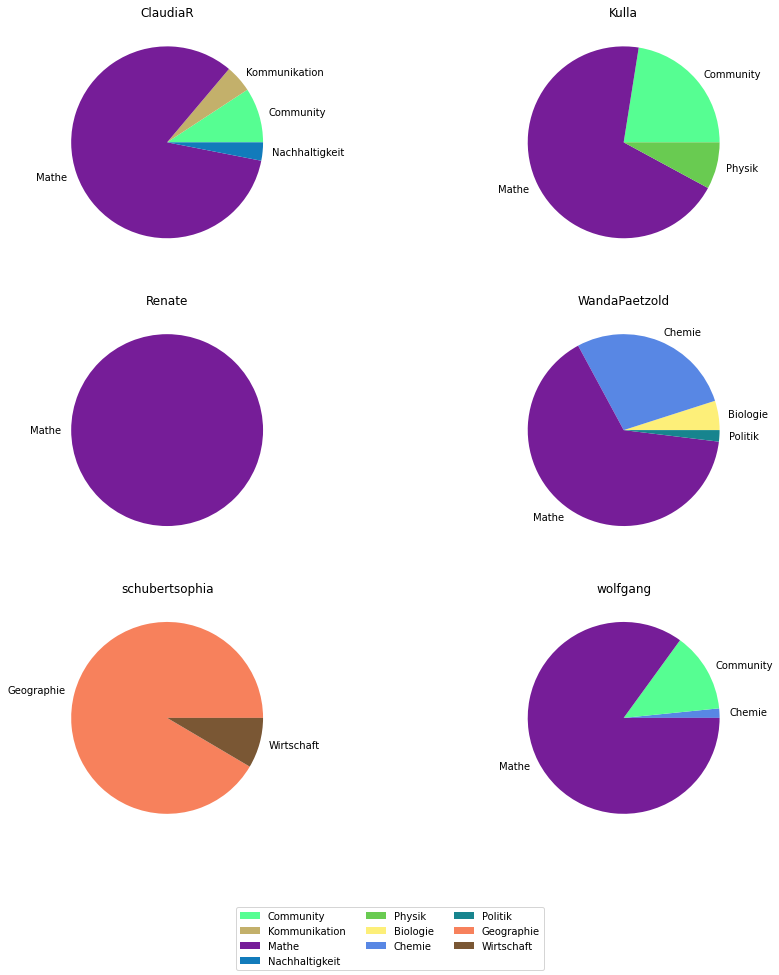

In [3]:
def text_to_random(text):
    random = Random()
    random.seed(text)
    
    return random
    
def text_to_random_rgb(text):
    random = text_to_random(text)
    
    r = random.randint(0,255)
    g = random.randint(0,255)
    b = random.randint(0,255)
    
    return Color(rgb=_normalise(r, g, b, mode="rgb")).hex

show_results(text_to_random_rgb)

Ein Problem dabei ist, dass die Farben unterschiedliche Helligkeit / Saturierungen aufweisen. Dies können wir umgehen, indem wir in den [HSL bzw HSV Farbraum](https://en.wikipedia.org/wiki/HSL_and_HSV) gehen. Im folgenden Beispiel ist der Farbwert (hue) zufällig, die brightness bei 0,5 und die Saturierung bei 0,75:

### Welche Farben gewählt werden:

### Wie die Diagramme zur Fachzugehörigkeit aussehen würden:

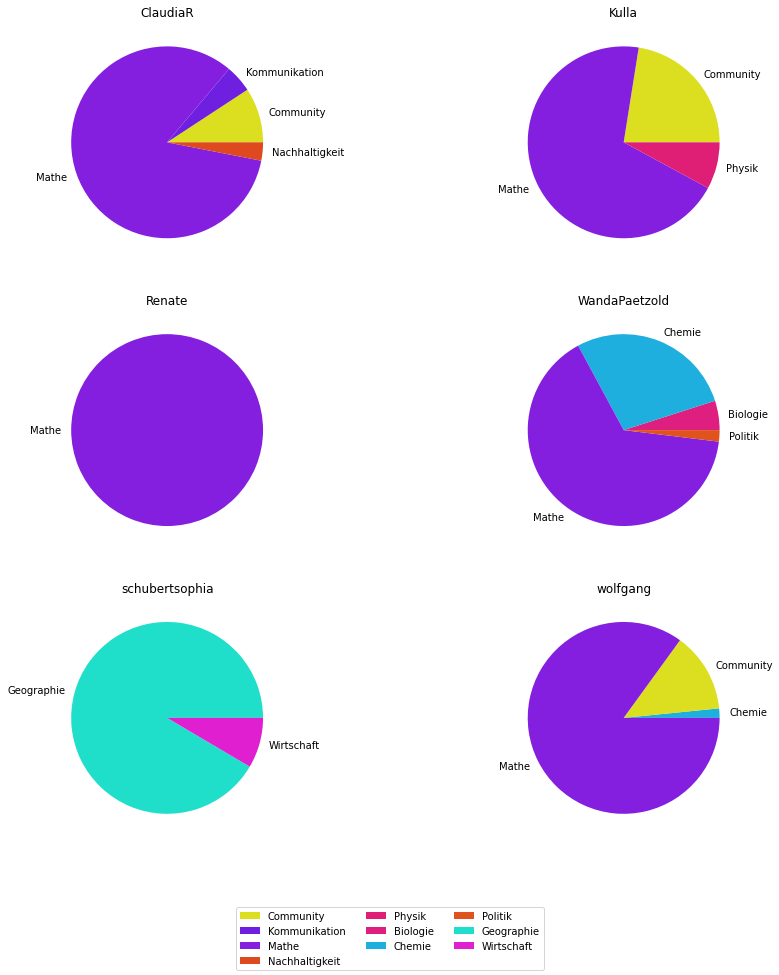

In [4]:
 def text_to_random_hsv(text):
    random = text_to_random(text)
    
    return Color(hls=(random.random(), 0.5, 0.75)).hex

show_results(text_to_random_hsv)

Nun ist das Problem, dass alle möglichen Farben ausgewählt werden, auch solche, die nicht zu unserem Farbdesign passen. Um Beispielsweise Rot-Lila auszuschließen, können wir uns aus Werte mit 40° <= hue <= 260° einschränken (im folgenden Beispiel ist außerdem 0,4 <= lightness <= 0.6 und 0,6 <= saturation <= 0,9) 

### Welche Farben gewählt werden:

### Wie die Diagramme zur Fachzugehörigkeit aussehen würden:

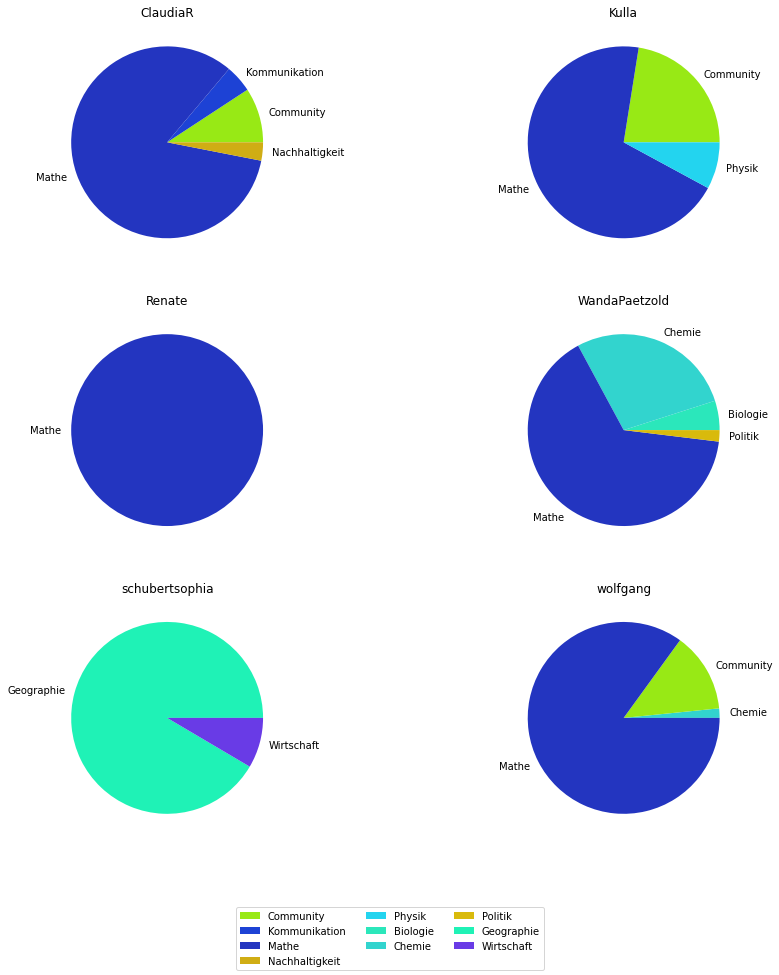

In [5]:
def text_to_random_hsv2(text):
    random = text_to_random(text)
    
    h = random.randint(40, 260) / 360
    l = random.uniform(0.4, 0.6)
    s = random.uniform(0.6, 0.9)
    
    return Color(hls=(h, l, s)).hex

show_results(text_to_random_hsv2)

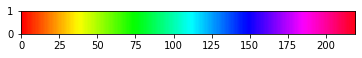

In [6]:
import numpy as np

gradient = (np.linspace(0, 1, 220) * 10 + 40) / 360
gradient = np.vstack((gradient, gradient))

plt.imshow(gradient, cmap="hsv", aspect=15)
plt.ylim(0,1)
plt.show()



### Welche Farben gewählt werden:

### Wie die Diagramme zur Fachzugehörigkeit aussehen würden:

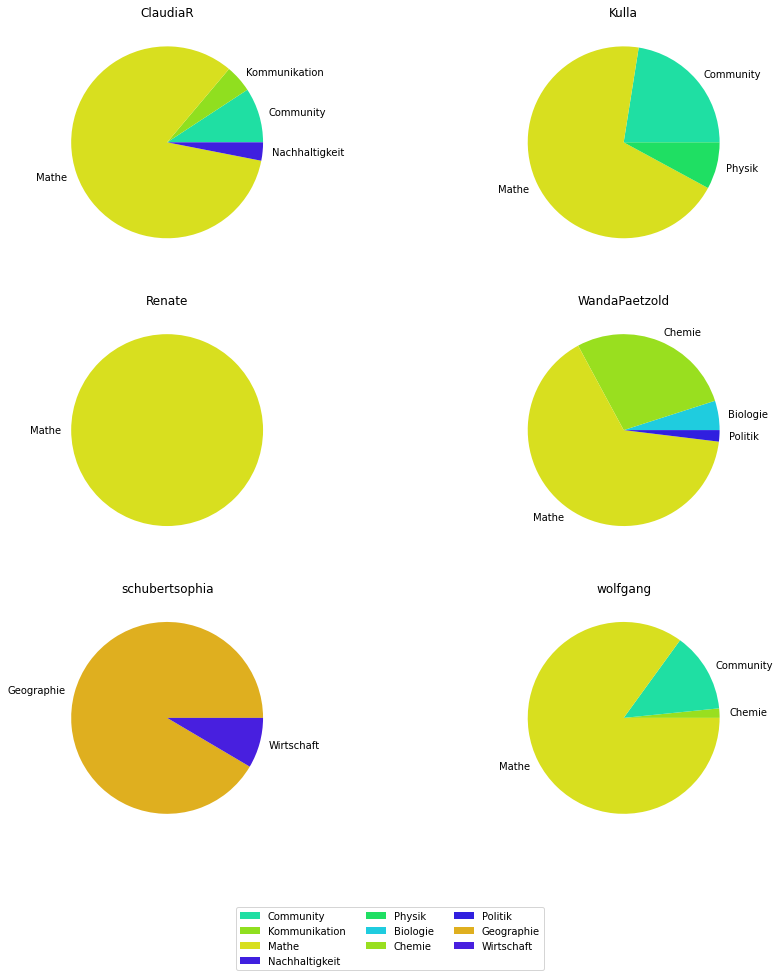

In [7]:
golden_ratio_conjugate = 0.618033988749895

id_of_text = dict()

def new_hsl_random_func(text):
    if text not in id_of_text:
        id_of_text[text] = len(id_of_text)
    
    nr = id_of_text[text]
    
    h = 0.1 + golden_ratio_conjugate * nr
    h %= 1
    h = (h * 220 + 40) / 360 
    
    return Color(hls=(h, 0.5, 0.75)).hex

show_results(new_hsl_random_func)

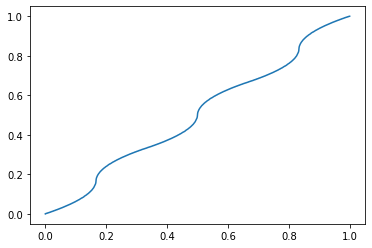

In [28]:
import numpy as np

def from_basic2(func):
    def g(x):
        x2 = (x-0.5)*2
        
        if x2 >= 0:
            return func(x2)/2+0.5
        else:
            return -func(-x2)/2+0.5
    
    return g

def from_basic(func):
    def f(x):
        a = 3*x
        b = math.floor(a)/3
        c = a - math.floor(a)

        return b + func(c)/3
    
    return f

def invert(func):
    def f(y):
        for x in np.linspace(0, 1, 1000):
            if func(x) >= y:
                return x
            
        return 1
    return f

n = 1.9473684210526314
g = from_basic(from_basic2(lambda x: x ** n))
f = invert(from_basic(from_basic2(lambda x: x ** n)))

xs = np.linspace(0,1,1000)
ys = np.vectorize(f)(xs)

plt.plot(xs, ys)

### Welche Farben gewählt werden:

### Wie die Diagramme zur Fachzugehörigkeit aussehen würden:

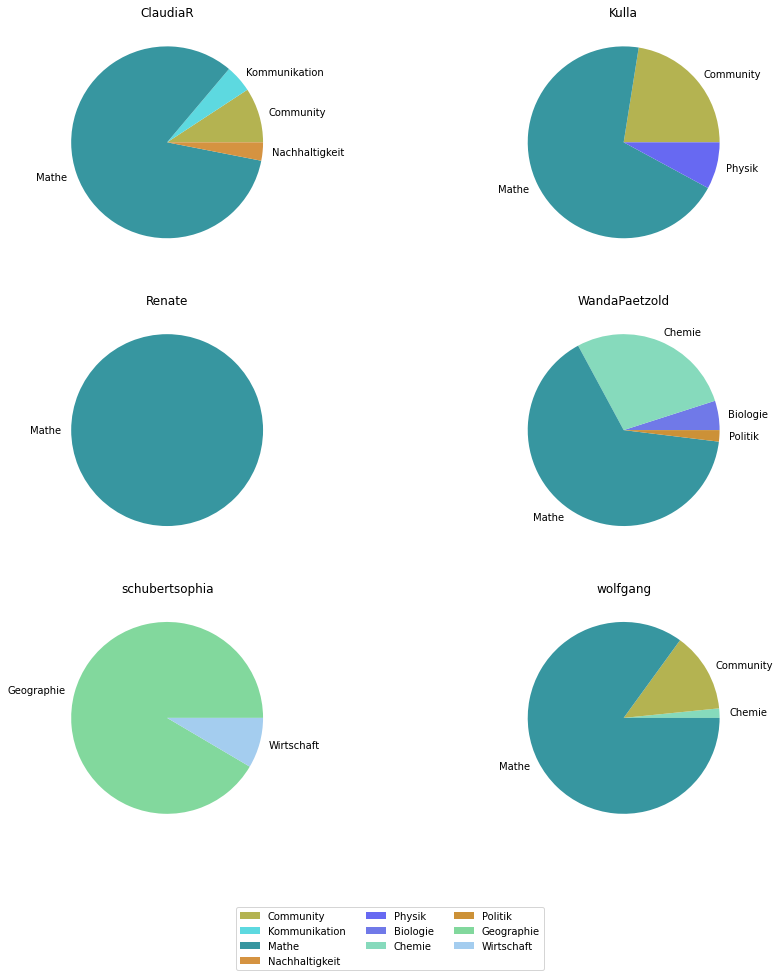

In [29]:
def text_to_random_hsv3(text):
    random = text_to_random(text)
    
    h = g(random.uniform(f(20/360), f(270/360)))
    l = random.uniform(0.4,0.8)
    s = random.uniform(0.4,0.9)
    
    return Color(hls=(h, l, s)).hex

show_results(text_to_random_hsv3)

### Welche Farben gewählt werden:

### Wie die Diagramme zur Fachzugehörigkeit aussehen würden:

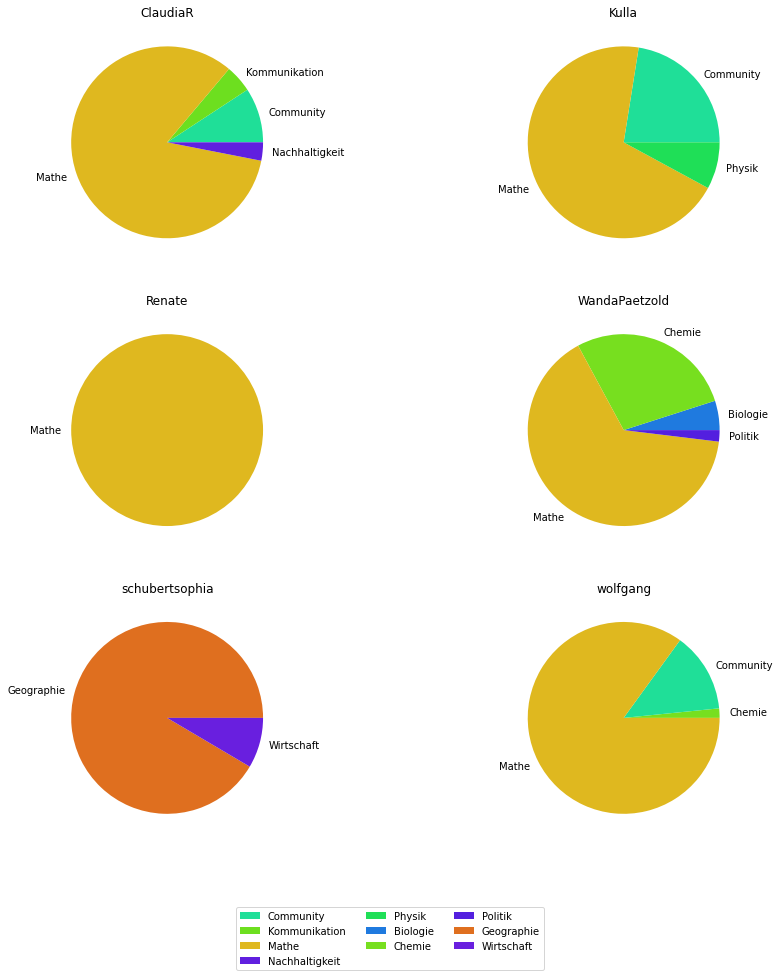

In [23]:
golden_ratio_conjugate = 0.618033988749895

id_of_text = dict()

def new_hsl_random_func(text):
    if text not in id_of_text:
        id_of_text[text] = len(id_of_text)
    
    nr = id_of_text[text]
    
    a = g(20/360)
    b = g(270/360)
    h = 0.1 + golden_ratio_conjugate * nr
    h %= 1
    h = f(h * (b-a) + a)
    
    return Color(hls=(h, 0.5, 0.75)).hex

show_results(new_hsl_random_func)